## DATA LOADING

### Approach:
- No Multiple LSTM models
- LSTM Models:
    a. Scale input and output
    b. Groupby SellerID+item_type and keep last 30 days transaction
    c. Drop Seller ID and train LSTM model (change architecture)
    
- Machine Learning:
    a. Consider- Recency
    b. past 3 quantities
    c. seller state, seller city, item_type
    d. 

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pylab
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [136]:
df= pd.read_csv("C:/Users/nishita/OneDrive/Desktop/RECYKAL/ml/ListingData-08062023.csv")

## DATA PROFILING

In [137]:
df.head()

,ListingID,created_on,SellerID,ItemName,Status,PurchasePrice,ListingQuantity
0,LT0122011,2022-01-01 15:20:44.572000,18752,PET Bottle Scrap Baled - Clear,REJECTED,50.0,10000
1,LT0122021,2022-01-02 03:45:47.866000,18607,PET Bottle Scrap Baled - Green,REJECTED,50.0,18000
2,LT0122022,2022-01-02 07:50:54.487000,19283,PET Bottle Scrap Baled - Clear,REJECTED,46.5,10000
3,LT0122023,2022-01-02 08:49:59.172000,19286,PET Bottle Scrap Baled - Clear,REJECTED,54.0,10000
4,LT0122024,2022-01-02 18:17:45.249000,19288,PET Liquor Bottle Scrap Baled - With Ring & Cap,REJECTED,100.0,7000


In [138]:
df.shape

(24440, 7)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24440 entries, 0 to 24439
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ListingID        24440 non-null  object 
 1   created_on       24440 non-null  object 
 2   SellerID         24440 non-null  int64  
 3   ItemName         24440 non-null  object 
 4   Status           24440 non-null  object 
 5   PurchasePrice    24440 non-null  float64
 6   ListingQuantity  24440 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 1.3+ MB


In [140]:
df.columns.values

array(['ListingID', 'created_on', 'SellerID', 'ItemName', 'Status',
       'PurchasePrice', 'ListingQuantity'], dtype=object)

In [141]:
df['date'] = pd.to_datetime(df["created_on"]).dt.date
df['date'] = pd.to_datetime(df["created_on"]).dt.normalize()

In [142]:
df.head()

,ListingID,created_on,SellerID,ItemName,Status,PurchasePrice,ListingQuantity,date
0,LT0122011,2022-01-01 15:20:44.572000,18752,PET Bottle Scrap Baled - Clear,REJECTED,50.0,10000,2022-01-01
1,LT0122021,2022-01-02 03:45:47.866000,18607,PET Bottle Scrap Baled - Green,REJECTED,50.0,18000,2022-01-02
2,LT0122022,2022-01-02 07:50:54.487000,19283,PET Bottle Scrap Baled - Clear,REJECTED,46.5,10000,2022-01-02
3,LT0122023,2022-01-02 08:49:59.172000,19286,PET Bottle Scrap Baled - Clear,REJECTED,54.0,10000,2022-01-02
4,LT0122024,2022-01-02 18:17:45.249000,19288,PET Liquor Bottle Scrap Baled - With Ring & Cap,REJECTED,100.0,7000,2022-01-02


In [143]:
df.tail()

,ListingID,created_on,SellerID,ItemName,Status,PurchasePrice,ListingQuantity,date
24435,LT1222314,2021-12-31 10:26:36.545000,19273,PET Bottle Scrap Baled - Clear,REJECTED,46.0,15000,2021-12-31
24436,LT1222315,2021-12-31 10:31:20.061000,19273,PET Bottle Scrap Baled - Clear,REJECTED,46.0,10000,2021-12-31
24437,LT1222316,2021-12-31 10:44:35.569000,6647,PET Bottle Scrap Baled - Clear,SOLD,45.4,15000,2021-12-31
24438,LT1222317,2021-12-31 14:24:53.560000,15094,PET Bottle Scrap Baled - Clear,SOLD,46.5,15000,2021-12-31
24439,LT1222318,2021-12-31 14:25:26.851000,15094,PET Bottle Scrap Baled - Clear,REJECTED,46.5,15000,2021-12-31


In [144]:
df['year'] = pd.DatetimeIndex(df['created_on']).year
df['month'] = pd.DatetimeIndex(df['created_on']).month

In [145]:
new_df=df.drop(["created_on","Status"],axis=1)

In [146]:
new_df.head()

,ListingID,SellerID,ItemName,PurchasePrice,ListingQuantity,date,year,month
0,LT0122011,18752,PET Bottle Scrap Baled - Clear,50.0,10000,2022-01-01,2022,1
1,LT0122021,18607,PET Bottle Scrap Baled - Green,50.0,18000,2022-01-02,2022,1
2,LT0122022,19283,PET Bottle Scrap Baled - Clear,46.5,10000,2022-01-02,2022,1
3,LT0122023,19286,PET Bottle Scrap Baled - Clear,54.0,10000,2022-01-02,2022,1
4,LT0122024,19288,PET Liquor Bottle Scrap Baled - With Ring & Cap,100.0,7000,2022-01-02,2022,1


## DATA CLEANING

In [147]:
new_df.isna().sum() #checking for missing data

ListingID          0
SellerID           0
ItemName           0
PurchasePrice      0
ListingQuantity    0
date               0
year               0
month              0
dtype: int64

In [148]:
new_df.isnull().sum()

ListingID          0
SellerID           0
ItemName           0
PurchasePrice      0
ListingQuantity    0
date               0
year               0
month              0
dtype: int64

In [149]:
new_df.drop_duplicates()

,ListingID,SellerID,ItemName,PurchasePrice,ListingQuantity,date,year,month
0,LT0122011,18752,PET Bottle Scrap Baled - Clear,50.0,10000,2022-01-01,2022,1
1,LT0122021,18607,PET Bottle Scrap Baled - Green,50.0,18000,2022-01-02,2022,1
2,LT0122022,19283,PET Bottle Scrap Baled - Clear,46.5,10000,2022-01-02,2022,1
3,LT0122023,19286,PET Bottle Scrap Baled - Clear,54.0,10000,2022-01-02,2022,1
4,LT0122024,19288,PET Liquor Bottle Scrap Baled - With Ring & Cap,100.0,7000,2022-01-02,2022,1
...,...,...,...,...,...,...,...,...
24435,LT1222314,19273,PET Bottle Scrap Baled - Clear,46.0,15000,2021-12-31,2021,12
24436,LT1222315,19273,PET Bottle Scrap Baled - Clear,46.0,10000,2021-12-31,2021,12
24437,LT1222316,6647,PET Bottle Scrap Baled - Clear,45.4,15000,2021-12-31,2021,12
24438,LT1222317,15094,PET Bottle Scrap Baled - Clear,46.5,15000,2021-12-31,2021,12


## EXPLORATORY DATA ANALYSIS

In [150]:
#Checking the number of sellers we are interacting with
new_df["SellerID"].nunique()

1491

In [151]:
#Plotting boxplots to check if outliers exists in the data

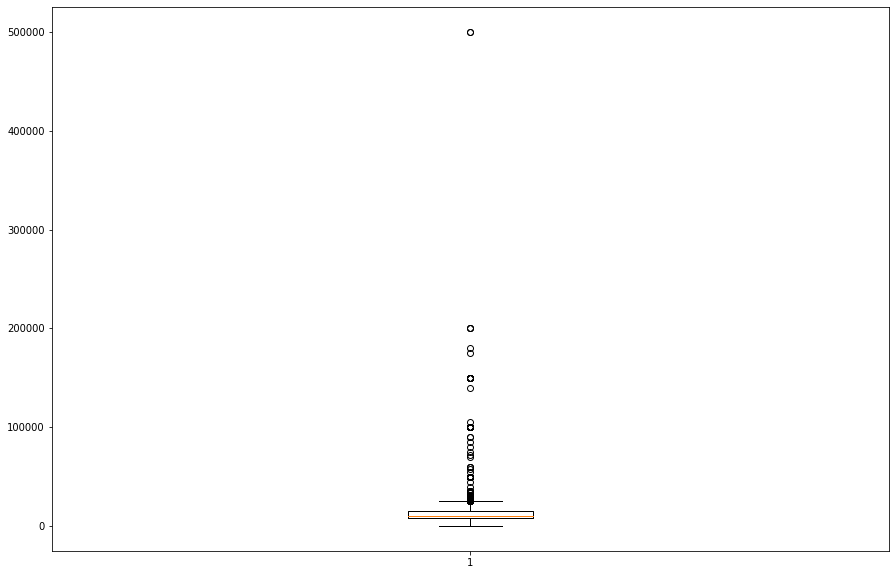

In [152]:
data = new_df["ListingQuantity"]
 
fig = plt.figure(figsize =(15,10))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

In [153]:
#removing the outliers from the listing quantity attribute
new_df = new_df[new_df['ListingQuantity'] < 25000]

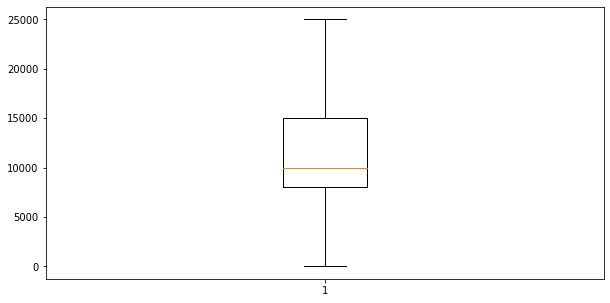

In [154]:
data = new_df["ListingQuantity"]
 
fig = plt.figure(figsize =(10, 5))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

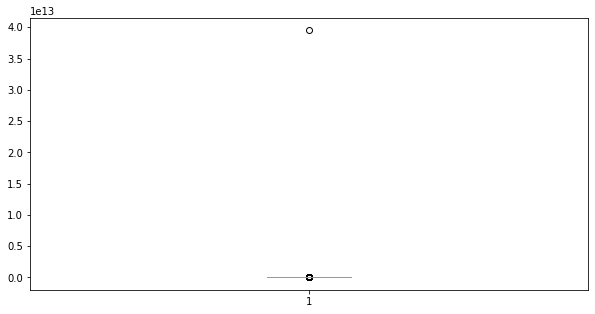

In [155]:
import matplotlib.pyplot as plt
data = new_df["PurchasePrice"]
 
fig = plt.figure(figsize =(10, 5))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

In [156]:
#removing the outliers from the purchase_price attribute
new_df=new_df[new_df["PurchasePrice"]<55]
new_df=new_df[new_df["PurchasePrice"]>30]

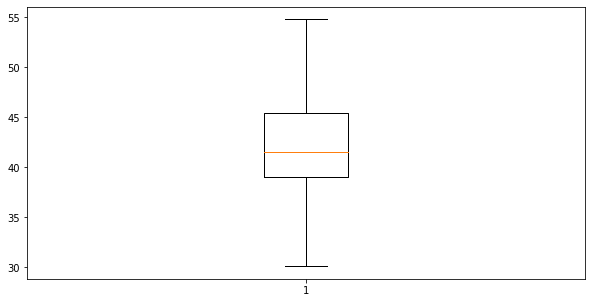

In [157]:
data = new_df["PurchasePrice"]
 
fig = plt.figure(figsize =(10, 5))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

In [158]:
#plotting pie chart for the explorarory analysis of status
column_to_plot = 'Status'
data_counts = df['Status'].value_counts()
print(data_counts)

SOLD           16478
REJECTED        5171
EXPIRED         2364
RETURN           190
DRAFT             97
ON_HOLD           62
IN_REVIEW         34
IN_PROGRESS       23
RESELL            14
APPROVED           6
RESOLD             1
Name: Status, dtype: int64


In [159]:
#plotting pie chart for the explorarory analysis of status
fig = px.pie(data_frame=df, values=data_counts.values, names=data_counts.index)
fig.show()

<AxesSubplot:>

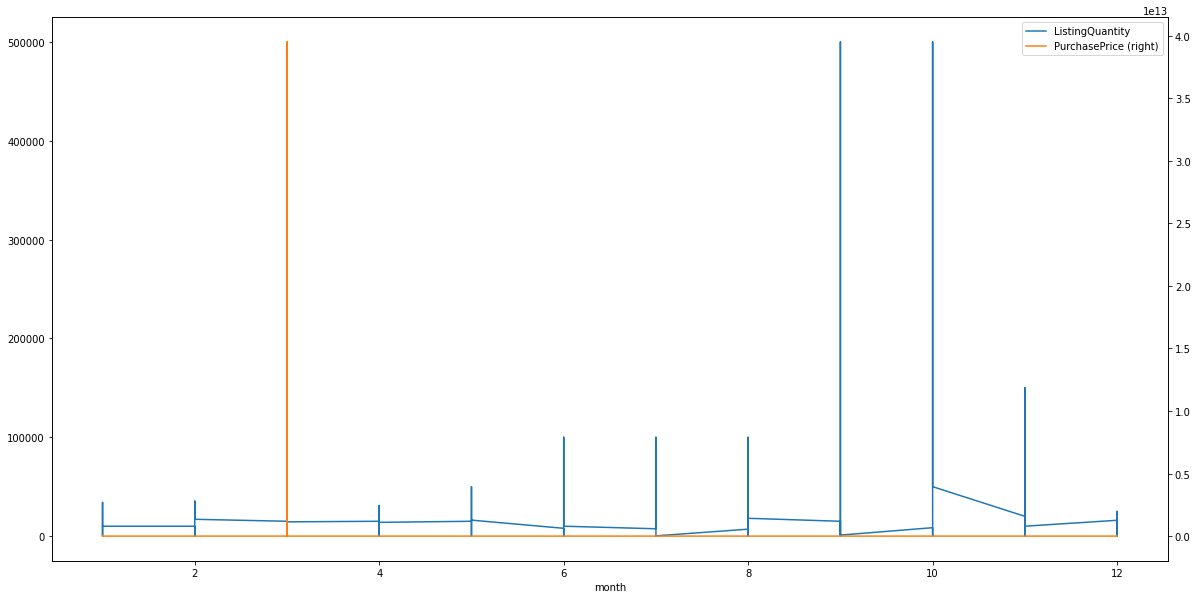

In [160]:
fig, ax = plt.subplots(figsize=(20,10)) 

df.plot(x = 'month', y = 'ListingQuantity',ax=ax) 
df.plot(x = 'month', y = 'PurchasePrice', ax = ax, secondary_y = True) 

In [161]:
fig = px.line(new_df, x="month", y="ListingQuantity", title="monthly listing of quantity ")
fig.show()

In [162]:
fig = px.line(new_df, x="month", y="PurchasePrice", title="monthly purchase price")
fig.show()

#calc freq of all the sellers-take 5 sellers with topmost frequency - plot line chart for every seller individually 
use rfm here - recncy frequenyc monetary


In [163]:
current_date = datetime.now()
new_df['Recency'] = (current_date - df['date']).dt.days

In [164]:
new_df.head()

,ListingID,SellerID,ItemName,PurchasePrice,ListingQuantity,date,year,month,Recency
0,LT0122011,18752,PET Bottle Scrap Baled - Clear,50.0,10000,2022-01-01,2022,1,535
1,LT0122021,18607,PET Bottle Scrap Baled - Green,50.0,18000,2022-01-02,2022,1,534
2,LT0122022,19283,PET Bottle Scrap Baled - Clear,46.5,10000,2022-01-02,2022,1,534
3,LT0122023,19286,PET Bottle Scrap Baled - Clear,54.0,10000,2022-01-02,2022,1,534
5,LT0122031,19290,PET Liquor Bottle Scrap Baled,50.0,7000,2022-01-03,2022,1,533


## code starts from here

In [165]:
frequency = new_df['SellerID'].value_counts()
new_df['frequency'] = new_df['SellerID'].map(frequency)

In [166]:
new_df.sort_index().sort_values("frequency",ascending=False)

,ListingID,SellerID,ItemName,PurchasePrice,ListingQuantity,date,year,month,Recency,frequency
17643,LT09221454,34953,Mix Scrap,40.6,11840,2022-09-14,2022,9,279,798
17719,LT09221536,34953,Mix Scrap,41.4,11260,2022-09-15,2022,9,278,798
17763,LT09221576,34953,Mix Scrap,41.5,10505,2022-09-15,2022,9,278,798
17762,LT09221575,34953,Mix Scrap,41.5,6710,2022-09-15,2022,9,278,798
17761,LT09221574,34953,Mix Scrap,41.5,9520,2022-09-15,2022,9,278,798
...,...,...,...,...,...,...,...,...,...,...
21125,LT10223119,35873,PET Bottle Scrap Baled - Clear,40.0,10000,2022-10-31,2022,10,232,1
21187,LT11210135,1021,PET Bottle Scrap Baled - Clear,52.0,15000,2021-11-01,2021,11,596,1
21212,LT1121036,13617,PET Bottle Scrap Baled - Clear,35.0,20000,2021-11-03,2021,11,594,1
21220,LT1121051,17285,PET Bottle Scrap Baled - Clear,50.0,10000,2021-11-05,2021,11,592,1


In [167]:
new_df= new_df[new_df["frequency"]>=30]
new_df.sort_index().sort_values("frequency",ascending=False)

,ListingID,SellerID,ItemName,PurchasePrice,ListingQuantity,date,year,month,Recency,frequency
17846,LT09221662,34953,Mix Scrap,41.3,11105,2022-09-16,2022,9,277,798
20161,LT10221021,34953,Mix Scrap,40.2,10845,2022-10-10,2022,10,253,798
1200,LT01231808,34953,Mix Scrap,40.0,9265,2023-01-18,2023,1,153,798
1201,LT01231809,34953,Mix Scrap,40.0,11250,2023-01-18,2023,1,153,798
17960,LT09221756,34953,HR/CR Steel Scrap,40.5,13100,2022-09-17,2022,9,276,798
...,...,...,...,...,...,...,...,...,...,...
11442,LT0622288,11454,PET Bottle Scrap Baled - Clear,45.5,10000,2022-06-28,2022,6,357,30
11441,LT0622287,11454,PET Bottle Scrap Baled - Clear,45.5,10000,2022-06-28,2022,6,357,30
6250,LT04230801,38462,PET Bottle Scrap Baled - Clear,42.3,8965,2023-04-08,2023,4,73,30
6251,LT04230801,38462,PET Bottle Scrap Baled - Green,39.3,630,2023-04-08,2023,4,73,30


In [208]:
try_df = new_df.groupby(['SellerID','ItemName','date'])['ListingQuantity'].mean()


In [209]:
# Example 2: Convert groupby object to DataFrame 
grouped_df = try_df.reset_index()

In [210]:
grouped_df = new_df.groupby(['SellerID','ItemName','date'], as_index = False)['ListingQuantity'].mean()

In [211]:
grouped_df = try_df.to_frame()

In [212]:
grouped_df

ListingQuantity
SellerID ItemName                       date                       
324      PET Bottle Scrap Baled - Clear 2022-04-15     15000.000000
                                        2022-04-22     15000.000000
                                        2022-04-25     15000.000000
                                        2022-05-02     15000.000000
                                        2022-05-05     10000.000000
...                                                             ...
39097    PET Bottle Scrap Baled - Green 2023-05-15       946.666667
                                        2023-05-20       640.000000
                                        2023-05-24       625.000000
                                        2023-05-25      1000.000000
         PP - Grinding                  2023-05-06     15000.000000

[6623 rows x 1 columns]

AttributeError: 'DataFrameGroupBy' object has no attribute 'to_frame'

In [200]:
print(type(try_df))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [ ]:
# Below are a quick example
# Example 1: Convert groupby Series
# Using groupby() & count() on multiple column
grouped_ser = df.groupby(['Courses', 'Duration'])['Fee'].count()

# Example 2: Convert groupby object to DataFrame 
grouped_df = grouped_ser.reset_index()

# Example 3: Use the as_index attribute to get groupby DataFrame
grouped_df = df.groupby(['Courses', 'Duration'], as_index = False)['Fee'].count()

# Example 4: Use the to_frame method
grouped_df = grouped_ser.to_frame()

In [170]:
df_sorted = new_df.sort_values(by=['SellerID', 'date'], ascending=[True, False])

In [196]:
grouped_transactions = df_sorted.groupby(['SellerID','ItemName','date'])

In [197]:
df_last_30_transactions = grouped_transactions.to_frame()

AttributeError: 'DataFrameGroupBy' object has no attribute 'to_frame'

In [193]:
df_last_30_transactions


In [177]:
len(df_last_30_transactions[df_last_30_transactions["SellerID"]==324])

30

In [178]:
copy_df = df_last_30_transactions.groupby(["date","SellerID","ItemName"])["ListingQuantity"].mean().reset_index()

In [179]:
copy_df

,date,SellerID,ItemName,ListingQuantity
0,2021-10-07,3781,PET Bottle Scrap Baled - Clear,16666.666667
1,2021-10-07,3781,PET Bottle Scrap Baled - Green,17666.666667
2,2021-10-07,3781,PET Liquor Bottle Scrap Baled,18333.333333
3,2021-10-07,3781,PET Liquor Bottle Scrap Baled - With Ring & Cap,20000.000000
4,2021-10-08,3781,PET Bottle Scrap Baled - Clear,11500.000000
...,...,...,...,...
2385,2023-06-07,38328,PET Bottle Scrap Baled - Clear,18000.000000
2386,2023-06-07,38455,Mix Scrap,15000.000000
2387,2023-06-07,38655,Mix Scrap,14575.000000
2388,2023-06-07,38730,Light Steel Scrap,6770.000000


In [180]:
#try_df=try_df.drop(["ListingID","SellerID","ItemName","PurchasePrice","year","month","Recency","frequency"],axis=1)

In [181]:
df_last_30_transactions=df_last_30_transactions.set_index("date")

In [182]:
df_last_30_transactions

,ListingID,SellerID,ItemName,PurchasePrice,ListingQuantity,year,month,Recency,frequency
date,,,,,,,,,
2023-05-17,LT05231703,324,PET Bottle Scrap Baled - Clear,36.75,7400,2023,5,34,190
2023-05-17,LT05231707,324,PET Bottle Scrap Baled - Clear,36.75,6705,2023,5,34,190
2023-05-09,LT052309024,324,PET Bottle Scrap Baled - Clear,37.00,7000,2023,5,42,190
2023-05-05,LT052305030,324,PET Bottle Scrap Baled - Clear,34.70,18000,2023,5,46,190
2023-05-05,LT052305031,324,PET Bottle Scrap Baled - Clear,36.95,15000,2023,5,46,190
...,...,...,...,...,...,...,...,...,...
2023-05-12,LT052312036,39097,PET Bottle Scrap Baled - Green,37.00,1000,2023,5,39,45
2023-05-12,LT05231208,39097,PET Bottle Scrap Baled - Clear,39.00,7250,2023,5,39,45
2023-05-12,LT05231208,39097,PET Bottle Scrap Baled - Green,37.00,730,2023,5,39,45


In [213]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [184]:
# Select the column to be scaled
columns_to_scale = ['ListingQuantity']
#column_data = df_last_30_transactions[column_name]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
#df_last_30_transactions['listing_quantity_scaled'] = df_last_30_transactions['ListingQuantity'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)))

# Display the updated DataFrame
#print(df)
# Apply Min-Max scaling to the selected columns while considering the 'date' column
df_last_30_transactions[columns_to_scale] = scaler.fit_transform(df_last_30_transactions[columns_to_scale])

In [185]:
df_last_30_transactions

,ListingID,SellerID,ItemName,PurchasePrice,ListingQuantity,year,month,Recency,frequency
date,,,,,,,,,
2023-05-17,LT05231703,324,PET Bottle Scrap Baled - Clear,36.75,0.296351,2023,5,34,190
2023-05-17,LT05231707,324,PET Bottle Scrap Baled - Clear,36.75,0.268454,2023,5,34,190
2023-05-09,LT052309024,324,PET Bottle Scrap Baled - Clear,37.00,0.280295,2023,5,42,190
2023-05-05,LT052305030,324,PET Bottle Scrap Baled - Clear,34.70,0.721832,2023,5,46,190
2023-05-05,LT052305031,324,PET Bottle Scrap Baled - Clear,36.95,0.601413,2023,5,46,190
...,...,...,...,...,...,...,...,...,...
2023-05-12,LT052312036,39097,PET Bottle Scrap Baled - Green,37.00,0.039457,2023,5,39,45
2023-05-12,LT05231208,39097,PET Bottle Scrap Baled - Clear,39.00,0.290330,2023,5,39,45
2023-05-12,LT05231208,39097,PET Bottle Scrap Baled - Green,37.00,0.028620,2023,5,39,45


In [186]:
copy_df=copy_df.drop(["SellerID","ItemName"],axis=1)

In [99]:
copy_df=copy_df.set_index("date")

In [100]:
copy_df

,ListingQuantity
date,
2021-10-07,16666.666667
2021-10-07,17666.666667
2021-10-07,18333.333333
2021-10-07,20000.000000
2021-10-08,11500.000000
...,...
2023-06-07,18000.000000
2023-06-07,15000.000000
2023-06-07,14575.000000


In [101]:
scaler = MinMaxScaler()
#df_last_30_transactions['listing_quantity_scaled'] = df_last_30_transactions['ListingQuantity'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)))

# Display the updated DataFrame
#print(df)
# Apply Min-Max scaling to the selected columns while considering the 'date' column
copy_df[columns_to_scale] = scaler.fit_transform(copy_df[["ListingQuantity"]])

In [102]:
copy_df

,ListingQuantity
date,
2021-10-07,0.667204
2021-10-07,0.707478
2021-10-07,0.734327
2021-10-07,0.801450
2021-10-08,0.459122
...,...
2023-06-07,0.720902
2023-06-07,0.600081
2023-06-07,0.582964


In [103]:
new_df.nunique()

ListingID          11995
SellerID             142
ItemName              42
PurchasePrice        486
ListingQuantity     2940
date                 600
year                   3
month                 12
Recency              600
frequency             86
dtype: int64

In [104]:
new_df["SellerID"].nunique()

142

In [546]:
filtered_df1.shape

(798, 10)

In [547]:
filtered_df1.head()

,ListingID,SellerID,ItemName,PurchasePrice,ListingQuantity,date,year,month,Recency,frequency
523,LT012307019,34953,Mix Scrap,39.5,8815,2023-01-07,2023,1,163,798
540,LT012308010,34953,Mix Scrap,39.5,6420,2023-01-08,2023,1,162,798
541,LT012308011,34953,Mix Scrap,39.5,8410,2023-01-08,2023,1,162,798
551,LT01230803,34953,Mix Scrap,39.5,6785,2023-01-08,2023,1,162,798
552,LT01230804,34953,Mix Scrap,39.5,6785,2023-01-08,2023,1,162,798


In [548]:
fig = px.line(filtered_df1, x='month', y='ListingQuantity', title='Listing Quantity Over Time')
fig.show()

array([<AxesSubplot:>], dtype=object)

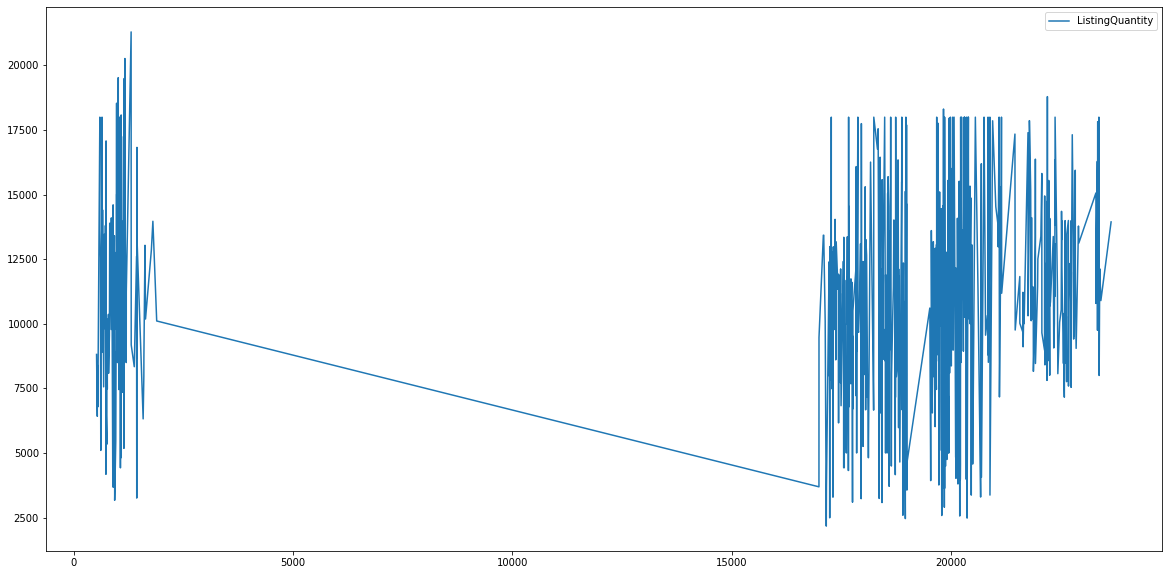

In [549]:
filtered_df1[["ListingQuantity"]].plot(subplots=True,figsize=(20, 10))

In [550]:
#filtered_df1=filtered_df1.set_index("date")
filtered_df1=filtered_df1.drop(["ListingID","SellerID","ItemName","PurchasePrice","year","month","Recency"],axis=1)
filtered_df1

,ListingQuantity,date,frequency
523,8815,2023-01-07,798
540,6420,2023-01-08,798
541,8410,2023-01-08,798
551,6785,2023-01-08,798
552,6785,2023-01-08,798
...,...,...,...
23375,11720,2022-12-05,798
23376,8000,2022-12-05,798
23389,12130,2022-12-05,798
23415,10900,2022-12-07,798


In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [106]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [107]:
# define input sequence
timeseries_data = df_last_30_transactions["ListingQuantity"]
# choose a number of time steps
n_steps = 30
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

In [109]:
print(X)
print(y)

[[0.2963513  0.26845422 0.28029543 ... 0.62168346 0.64677076 0.72183198]
 [0.26845422 0.28029543 0.72183198 ... 0.64677076 0.72183198 0.60141292]
 [0.28029543 0.72183198 0.60141292 ... 0.72183198 0.60141292 0.32043511]
 ...
 [0.36539156 0.500863   0.44767792 ... 0.24015574 0.03945731 0.29033035]
 [0.500863   0.44767792 0.28029543 ... 0.03945731 0.29033035 0.0286196 ]
 [0.44767792 0.28029543 0.40071449 ... 0.29033035 0.0286196  0.53839361]]
[0.60141292 0.32043511 0.32043511 ... 0.0286196  0.53839361 0.05752017]


In [110]:
X.shape

(4230, 30)

In [111]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [113]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# fit model
model.fit(X, y, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
106/106 [==============================] - 10s 74ms/step - loss: 0.0670 - val_loss: 0.0475
Epoch 2/100
106/106 [==============================] - 8s 72ms/step - loss: 0.0380 - val_loss: 0.0444
Epoch 3/100
106/106 [==============================] - 8s 72ms/step - loss: 0.0353 - val_loss: 0.0419
Epoch 4/100
106/106 [==============================] - 7s 70ms/step - loss: 0.0354 - val_loss: 0.0420
Epoch 5/100
106/106 [==============================] - 8s 73ms/step - loss: 0.0342 - val_loss: 0.0410
Epoch 6/100
106/106 [==============================] - 8s 72ms/step - loss: 0.0340 - val_loss: 0.0409
Epoch 7/100
106/106 [==============================] - 8s 73ms/step - loss: 0.0341 - val_loss: 0.0406
Epoch 8/100
106/106 [==============================] - 8s 74ms/step - loss: 0.0340 - val_loss: 0.0401
Epoch 9/100
106/106 [==============================] - 8s 73ms/step - loss: 0.0335 - val_loss: 0.0397
Epoch 10/100
106/106 [==============================] - 8s 74ms/step - loss: 0.03

In [671]:
# define input sequence
timeseries_data = copy_df["ListingQuantity"]
# choose a number of time steps
n_steps = 30
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

In [216]:
print(X[0])



[[0.2963513 ]
 [0.26845422]
 [0.28029543]
 [0.72183198]
 [0.60141292]
 [0.60141292]
 [0.60141292]
 [0.60141292]
 [0.3862642 ]
 [0.72183198]
 [0.60141292]
 [0.40071449]
 [0.40071449]
 [0.40071449]
 [0.40071449]
 [0.70517401]
 [0.72183198]
 [0.60141292]
 [0.72263477]
 [0.72303617]
 [0.61104644]
 [0.61024365]
 [0.72223337]
 [0.68771324]
 [0.66242524]
 [0.64074981]
 [0.01135953]
 [0.62168346]
 [0.64677076]
 [0.72183198]]


In [673]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [674]:
X.shape

(2360, 30, 1)

In [675]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# fit model
model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20
74/74 [==============================] - 13s 82ms/step - loss: 0.0956
Epoch 2/20
74/74 [==============================] - 6s 79ms/step - loss: 0.0615
Epoch 3/20
74/74 [==============================] - 6s 87ms/step - loss: 0.0622
Epoch 4/20
74/74 [==============================] - 6s 82ms/step - loss: 0.0606
Epoch 5/20
74/74 [==============================] - 6s 81ms/step - loss: 0.0609
Epoch 6/20
74/74 [==============================] - 6s 82ms/step - loss: 0.0617
Epoch 7/20
74/74 [==============================] - 6s 82ms/step - loss: 0.0611
Epoch 8/20
74/74 [==============================] - 6s 81ms/step - loss: 0.0610
Epoch 9/20
74/74 [==============================] - 6s 82ms/step - loss: 0.0606
Epoch 10/20
74/74 [==============================] - 6s 83ms/step - loss: 0.0613
Epoch 11/20
74/74 [==============================] - 6s 82ms/step - loss: 0.0605
Epoch 12/20
74/74 [==============================] - 6s 84ms/step - loss: 0.0609
Epoch 13/20
74/74 [=================

In [217]:
# demonstrate prediction for next 10 days
x_input = np.array([8000,12130,10900])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<10):
    
    if(len(temp_input)>3):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

ValueError: cannot reshape array of size 3 into shape (1,30,1)

In [ ]:
timeseries_data

In [ ]:
lst_output

In [ ]:
day_new=np.arange(1,799)
day_pred=np.arange(10,20)
plt.plot(day_new,timeseries_data)
plt.plot(day_pred,lst_output)
plt.figure(figsize=(40,40))

In [ ]:
##filtered_df2=filtered_df2.set_index("date")
filtered_df2

In [ ]:
filtered_df2[["ListingQuantity"]].plot(subplots=True,figsize=(20, 10))

In [ ]:
# define input sequence
timeseries_data = filtered_df2["ListingQuantity"]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

In [ ]:
print(X),print(y)

In [ ]:
X.shape

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=1)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
# Define model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=300, verbose=1)

# Make predictions
y_pred = model.predict(X)

# Calculate RMSE
rmse = calculate_rmse(y, y_pred)
print("RMSE:", rmse)

In [ ]:
filtered_df2 = new_df[new_df["SellerID"] == 34274]
fig = px.line(filtered_df2, x='month', y='ListingQuantity', title='Listing Quantity Over Time')
fig.show()

filtered_df3 = new_df[new_df["SellerID"] == 12186]
fig = px.line(filtered_df3, x='month', y='ListingQuantity', title='Listing Quantity Over Time')
fig.show()

filtered_df4 = new_df[new_df["SellerID"] == 30686]
fig = px.line(filtered_df4, x='month', y='ListingQuantity', title='Listing Quantity Over Time')
fig.show()

filtered_df5 = new_df[new_df["SellerID"] == 31036]
fig = px.line(filtered_df5, x='month', y='ListingQuantity', title='Listing Quantity Over Time')
fig.show()

filtered_df5.head()

filtered_df5.describe()

plt.plot(filtered_df5["month"], filtered_df5["ListingQuantity"])
plt.show()